**주요 내용**

1일부터 14일 동안 방류량의 평균값의 중요도를 측정하고자 한다.
이를 위해 데이터를 모두 1일 평균값의 데이터로 전환한다.

## 필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error

In [3]:
# 운영체제에 따른 한글 지원을 설정한다. 지원되는 환경은 윈도우, 우분투, 구글 코랩 등이다.

import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/gulim.ttc"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

## 승촌보 수질 데이터 불러오기

보 이름

In [4]:
reservoir = 'Seungchonbo'

데이터 저장소

In [5]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"

승촌보 데이터 불러오기. `'측정일/월'` 특성은 date time으로 파싱.

In [6]:
data_file = reservoir+".xlsx"
scb_yearly = pd.read_excel(base_path+data_file, 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

**주의사항**

아래 함수는 시간특성에 대한 파싱이 제대로 실행되지 않았을 경우 수동으로 시간 특성을 '년.월.일 시' 형식으로 변환한다.
파싱이 제대로 되지 않은(않았던) 이유는 원본 엑셀 파일에 일부 데이터의 시간이 0시 0분 대신 12시 0분으로 표기되었기 때문이다.

In [7]:
# 연도별로 별도로 작동한다.

def time2datetime(df_yearly_dict, feature):
    for year in list(df_yearly_dict.keys()):
        df_yearly_dict[year][feature] = df_yearly_dict[year][feature].apply(lambda x : x.strftime('%Y-%m-%d %H'))
    
    return df_yearly_dict

'측정일/월' 특성을 '년-월-일 시'형식으로 변경한다.

In [8]:
scb_yearly = time2datetime(scb_yearly, '측정일/월')

2012년도 데이터를 제외한 모든 데이터 통합 함수

In [9]:
# 반환값은 데이터프레임

def concat_yearly_df(df_yearly_dict):
    df_concat = pd.DataFrame()

    for year in list(df_yearly_dict.keys())[1:]:
        df_concat = pd.concat([df_concat, df_yearly_dict[year]])

    return df_concat

### 연도별 수질 데이터 통합

In [10]:
# 2013년도부터 통합
scb_yearly_df13 = concat_yearly_df(scb_yearly)

# 인덱스 재설정
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

## 승촌보 유량 데이터 추가

`시간` 특성은 date time으로 파싱해서 불러온다.

In [11]:
flow_data_file = reservoir+"_flow.xlsx"
scb_flow_yearly = pd.read_excel(base_path+flow_data_file, 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

시간 특성을 '년-월-일 시'형식으로 변경한다.

In [12]:
scb_flow_yearly = time2datetime(scb_flow_yearly, '시간')

**10분 단위를 1시간 단위로 변경**  

시간별 평균값을 활용한다.

In [13]:
scb_flow_yearly_hour = {}

# groupby의 as_index=False 옵션 사용. 인덱스 자동 재설정됨.
for year in list(scb_flow_yearly.keys()):
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('시간', as_index=False).mean()

### 연도별 유량 데이터 통합

In [14]:
# 2013년부터 통합
scb_flow_yearly_hour_df = concat_yearly_df(scb_flow_yearly_hour)

# 인덱스 재설정
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

## 수질/유량 데이터 합병  

수질 데이터와 유량 데이터를 `측정일/월`과 `시간` 기준으로 합병한다.

In [15]:
# 수질 데이터의 `측정일/월` 특성 이름을 `시간`으로 변경
scb_yearly_df13 = scb_yearly_df13.rename(columns={'측정일/월':'시간'})

# `pd.merge()`에서 `how = 'outer'` 키워드 인자 : 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다(합집합).
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

# 유량 데이터 2022년도 데이터를 더 많이 포함하기에 삭제 필요.
scb_data = scb_data[:len(scb_yearly_df13)]

# 유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

## 데이터셋 전처리

### 특성 선택

훈련에 사용하지 않을 특성 삭제

In [16]:
# scb_data.drop(['측정소명', '수소이온농도', '용존산소 mg/L'], axis=1, inplace=True)
scb_data.drop(['측정소명', '수소이온농도', '용존산소 mg/L', '하류수위(EL.m)', '유입량(㎥/s)'], axis=1, inplace=True)

In [17]:
scb_data.columns

Index(['시간', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

### 클로로필 정규화

회귀 모델을 적용하기 전에 클로로필 값이 정규 분포인지 확인. 왼쪽으로 치우친 형태임.

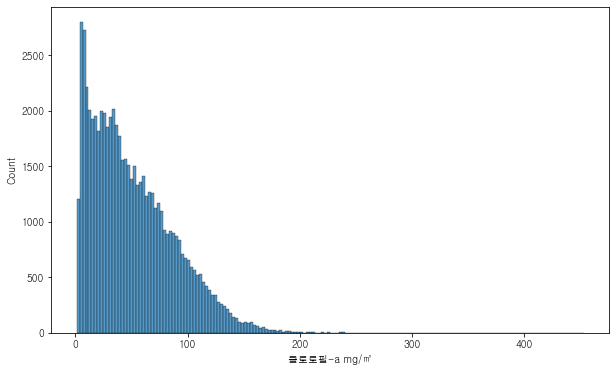

In [18]:
sns.histplot(scb_data['클로로필-a mg/㎥'])
plt.show()

`np.log1p()`를 사용해 로그변환하면 클로로필 값이 정규 분포에 가까워짐 

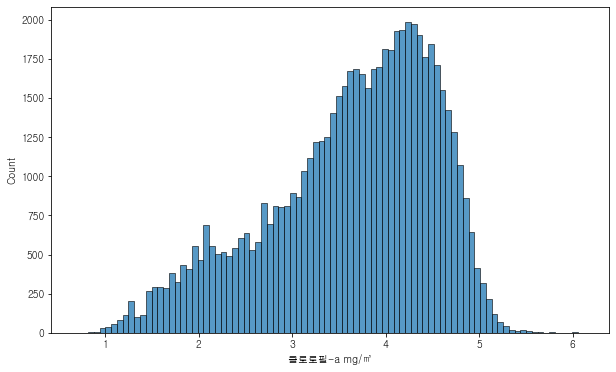

In [19]:
sns.histplot(np.log1p(scb_data['클로로필-a mg/㎥']))
plt.show()

클로로필 값을 로그 변환 뒤 `scb_data`에 추가

In [20]:
scb_data['log_Chl-a'] = np.log1p(scb_data['클로로필-a mg/㎥'])

In [21]:
scb_data.head(3)

,시간,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
0,2013-01-01 00,3.9,374.0,2.5,NaN,NaN,7.2,7.5,19.748333,2.104134
1,2013-01-01 01,3.9,375.0,2.5,NaN,NaN,6.9,7.5,19.706667,2.066863
2,2013-01-01 02,4.0,374.0,2.5,NaN,NaN,6.8,7.5,19.723333,2.054124


## 방류량 평균값 활용

**주의사항**

1일부터 14일 동안 방류량의 평균값의 중요도를 측정하고자 한다.
이를 위해 데이터를 모두 1일 평균값의 데이터로 전환한다.

먼저 데이터셋을 복제해서 원본은 유지한다.

In [22]:
scb_df = scb_data.copy()

In [23]:
scb_df.columns

Index(['시간', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', 'log_Chl-a'],
      dtype='object')

### 1시간 단위로 정리된 데이터를 1일 단위로 변경  

모든 특성의 일별 평균값을 이용한다.

In [24]:
scb_df['시간'] = scb_df['시간'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H').strftime('%Y-%m-%d'))

# groupby의 as_index=False 옵션 사용. 인덱스 자동 재설정됨.
scb_df_daily = scb_df.groupby('시간', as_index=False).mean()

scb_df_daily.head()

,시간,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
0,2013-01-01,4.113043,406.391304,2.791667,NaN,NaN,7.025000,7.490903,18.733472,2.082450
1,2013-01-02,4.282609,431.260870,2.839130,NaN,NaN,7.056522,7.501458,18.929167,2.086322
2,2013-01-03,3.830435,416.565217,3.058333,NaN,NaN,7.195833,7.499236,16.621250,2.103194
3,2013-01-04,3.313043,402.000000,2.730435,NaN,NaN,7.126087,7.489722,15.805556,2.094838
4,2013-01-05,3.165217,409.304348,2.800000,NaN,NaN,7.220833,7.494722,13.062361,2.106349


In [25]:
scb_df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3430 entries, 0 to 3429
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           3430 non-null   object 
 1   수온 ℃         2849 non-null   float64
 2   전기전도도 μS/cm  2849 non-null   float64
 3   총유기탄소 mg/L   2682 non-null   float64
 4   총질소 mg/L     2698 non-null   float64
 5   총인 mg/L      2691 non-null   float64
 6   클로로필-a mg/㎥  2772 non-null   float64
 7   상류수위(EL.m)   3430 non-null   float64
 8   방류량(㎥/s)     3430 non-null   float64
 9   log_Chl-a    2772 non-null   float64
dtypes: float64(9), object(1)
memory usage: 268.1+ KB


### 훈련 특성과 타깃  

- 훈련 특성: 측정소명과 클로로필을 제외한 특성 + 최대 14일 동안의 방류량/수온 평균값
- 타깃 특성: `log_Chl-a`

In [26]:
scb_df_daily.columns

Index(['시간', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', 'log_Chl-a'],
      dtype='object')

In [27]:
features_to_remove = ['시간', '클로로필-a mg/㎥', 'log_Chl-a']
basic_features = ['수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)']


아래 함수는 지정된 특성에 대해 윈도우 크기만큼의 기간동안의 평균값을 특성으로 추가한다.

In [28]:
from pandas import DataFrame
import re

def feature_windowing(df : DataFrame, feature : str, window: int) -> None:
    feature_ = re.split(' |\(', feature)[0] # 공백 또는 여는 괄호 기준 쪼개기 후 특성 이름만 사용. 단위 등은 삭제됨. 

    new_features = dict()
    new_features[str(window) + 'window' + feature_] = df[feature].rolling(window=window, min_periods=1).mean() # 1개 이상의 값이 있는 경우 평균값 계산
    
    new_features = pd.DataFrame(new_features)

    return pd.concat([df, new_features], axis=1)

## 모델 훈련

### GradientBoosting

In [29]:
gb_reg = GradientBoostingRegressor(random_state=42)

이전 훈련 결과에 의해 하이퍼파라미터의 아래 조합이 가장 좋은 성능을 보였음.
따라서 여기서는 훈련 시간을 절약하기 위해 하나의 조합만 사용함.

In [30]:
parameters = {'n_estimators':[1200], 'max_depth':[25], 'min_samples_leaf':[10]}

그리드 탐색 실행 함수

- 모델, 하이퍼파라미터 조합, 특성, 윈도우 크기가 정해지면 해당 특성의 지정된 크기만큼의 
    윈도우 기간 동안의 평균값을 새로운 특성으로 추가함.
- 윈도우의 단위는 일(day)

In [31]:
def gridsearch(model, parameters, feature, windows, cv=3):

      # best models
    best_model_dict = dict()
    # test scores of the best models
    test_score_dict = dict()
    # train features of the best models
    input_features_dict = dict()

    for window in windows:
        # window 특성 추가
        scb_df_daily_window = feature_windowing(scb_df_daily, feature, window)
        # 결측치 제거
        scb_df_daily_window.dropna(inplace=True)

        # 입력 및 타깃 특성 지정
        features_to_remove_ = features_to_remove + [feature]

        features_ = list(scb_df_daily_window.columns)
        print(features_)
        for ft in features_to_remove_:
          features_.remove(ft)
        
        print(features_)
        input_features = features_
        target_feature = 'log_Chl-a'

        # 입력 및 타깃 데이터셋 지정
        inputs = scb_df_daily_window.loc[:, input_features]
        targets = scb_df_daily_window[target_feature]

        # 훈련셋과 테스트셋 분리
        X_train, X_test, y_train, y_test = train_test_split(inputs, targets, random_state=42)

        added_feature = input_features[-1]
        print(f"==={added_feature} 모델 훈련===")
        # 그리드 탐색 훈련 시작
        model_grid = GridSearchCV(model, param_grid=parameters, cv=cv, verbose=5)
        model_grid.fit(X_train, y_train)

        estimator = model_grid.best_estimator_

        best_model_dict[added_feature] = estimator
        test_score_dict[added_feature] = estimator.score(X_test, y_test)
        input_features_dict[added_feature] = input_features

    return best_model_dict, test_score_dict, input_features_dict


방류량을 기준으로 1일부터 14일까지의 윈도우를 개별적으로 적용하여 훈련한다.

In [32]:
window_feature = '방류량(㎥/s)'
windows = range(1, 15)
best_model_dict, test_score_dict, input_features_dict = gridsearch(gb_reg, parameters, window_feature, windows, cv=3)

['시간', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', 'log_Chl-a', '1window방류량']
['수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '1window방류량']
===1window방류량 모델 훈련===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=25, min_samples_leaf=10, n_estimators=1200;, score=0.716 total time=   8.7s
[CV 2/3] END max_depth=25, min_samples_leaf=10, n_estimators=1200;, score=0.728 total time=   9.1s
[CV 3/3] END max_depth=25, min_samples_leaf=10, n_estimators=1200;, score=0.764 total time=   9.0s
['시간', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', 'log_Chl-a', '2window방류량']
['수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '2window방류량']
===2window방류량 모델 훈련===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=25, min_samples_leaf=10, n_estimators=1200;, score=0.740 total time=

아래 함수는 훈련 후 각 특성의 중요도를 그래프로 그린다.

In [33]:
def feature_importance_barplot(best_model_dict, input_features_dict):
    models_trained = best_model_dict.keys()
    num_of_models = len(models_trained)

    fig, axs = plt.subplots(num_of_models, sharex=True, figsize=(10, num_of_models*4))

    for idx, model_ in enumerate(models_trained):
        ax = axs[idx]
        estimator_ = best_model_dict[model_]
        input_features_ = input_features_dict[model_]


        feature_series = pd.Series(data = estimator_.feature_importances_, index = input_features_)
        feature_series = feature_series.sort_values(ascending = False)

        colors = pd.Series('gray', index=feature_series.index)
        colors[input_features_[-1]] = 'red'
        
        sns.barplot(ax=ax, x = feature_series[:10], y = feature_series.index[:10], palette=colors)
        ax.set_title(model_)

    plt.subplots_adjust(hspace=0.4, wspace=0)
    plt.show()

윈도우 크기 1부터 14까지 훈련시킨 결과 각 특성의 중요도를 그래프로 그리면 다음과 같다.

- 윈도우 크기 7까지 방류량 중요도가 가장 높음.
- 윈도우 크기 4까지 방류량의 중요도가 계속 증가함.

<Figure size 1440x7200 with 0 Axes>

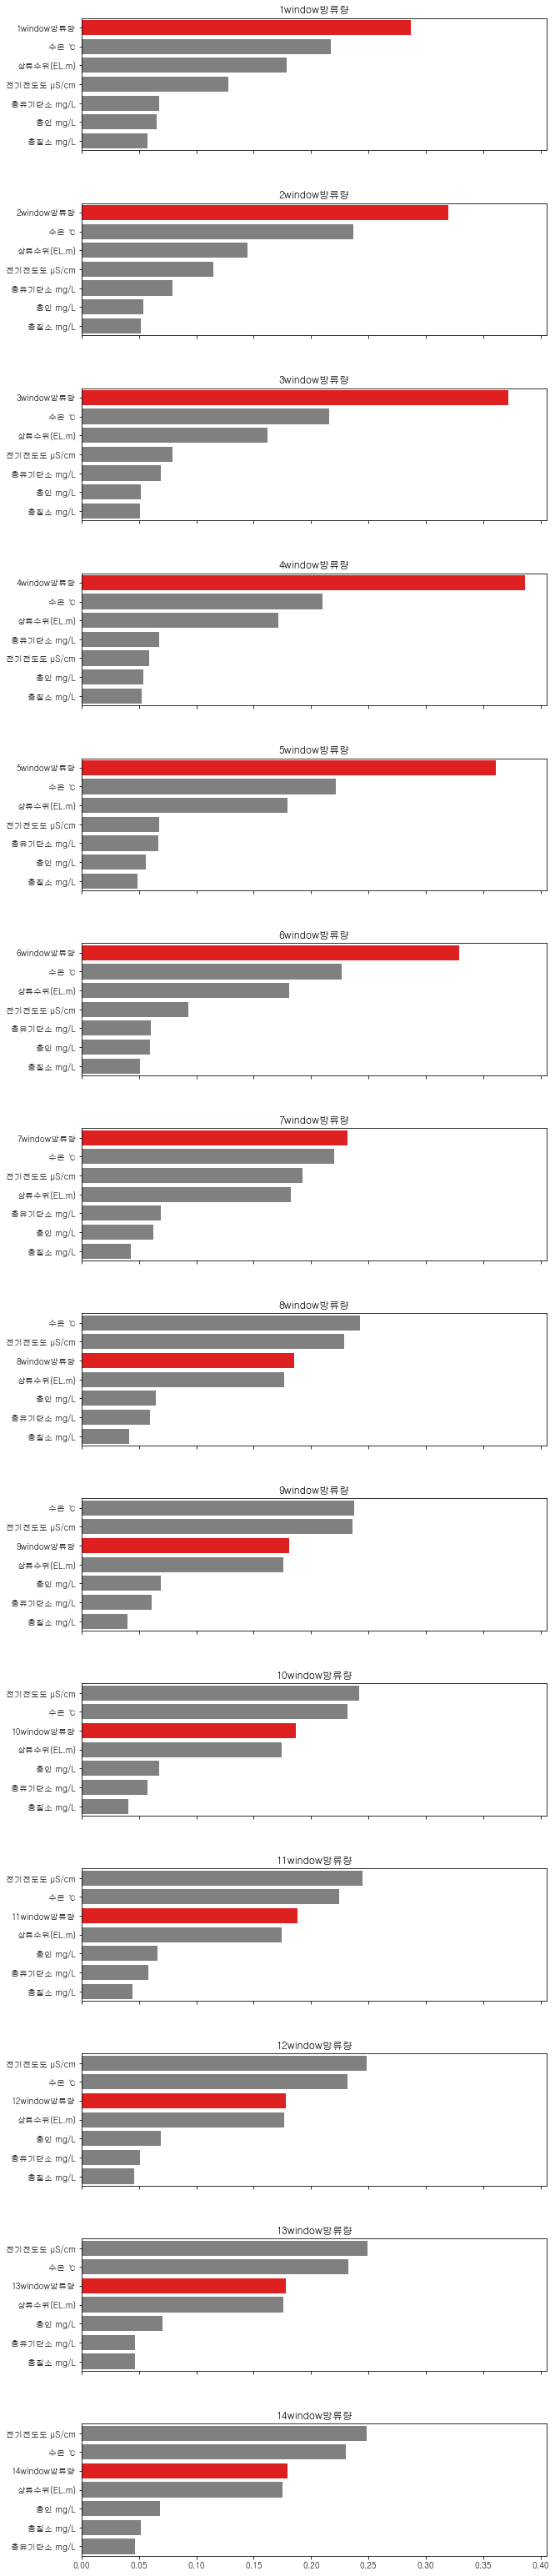

In [34]:
plt.figure(figsize=(20, 100))

feature_importance_barplot(best_model_dict, input_features_dict)

아래 그래프는 윈도우 크기에 따른 모델의 테스트 성능(score 기준)의 
변화를 보여준다. 윈도우 크기 3에서 14까지 성능이 비슷하다.

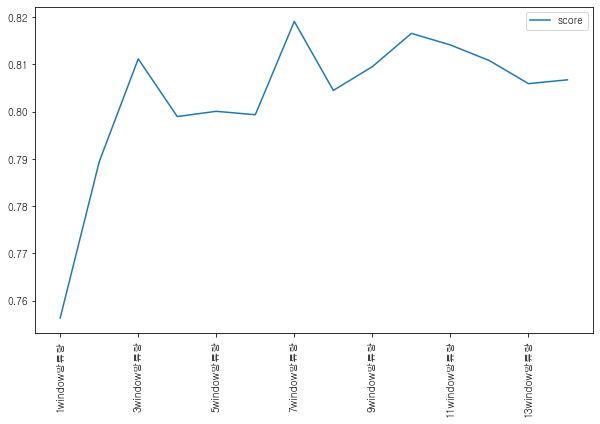

In [35]:
score_df = pd.DataFrame(test_score_dict, index=['score']).T
score_df.plot()
plt.xticks(rotation=90)
plt.show()